In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

/Users/michaelc.c.h/opt/miniconda3/envs/brain2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from bioinfokit.analys import stat

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from pingouin import ancova

## Description

Compute subset groups of gradients and see how stable the extracted gradients are for each movies. 

GOAL: Evaluate "stability" across subsamples of subjects-generated gradients

In [3]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

In [5]:
mri_path = "./data/fmri400_compiled/"
print(os.listdir(mri_path))

movie_name   = os.listdir(mri_path)[14]
mri_df       = pd.read_csv(mri_path + movie_name)

film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
duration_film =  int(film_duration/ TR) # in number of TRs
front_pad     = int(WASH + ONSET) + 1

## Table of Contents
- [Stability](#stable)
    - Stability across movies
    - Stability across subjects

- [ANCOVA](#ancova)

- [One-Way ANOVA](#anova)

### Stability

#### STABILITY ACROSS MOVIES

##### Generate gradients from subsets of subjects per movie

In [20]:
subject = 13
permovie = {}
for f in os.listdir('./data/fMRIFiles/TRFiles/'):
    moviename = f.split('_')[-1][:-4]
    if moviename == 'Rest': continue
    if '400' in f and str(subject) in f:
        permovie[moviename] = np.loadtxt('./data/fMRIFiles/TRFiles/{}'.format(f), delimiter=',')

In [78]:
np.random.seed(10)
nb_per_sample = 10
movies = list(permovie.keys())
samples_names = []
samples_grad  = []
nbs = 100
for _ in range(nbs):
    samples_names.append(np.random.choice(movies, nb_per_sample, replace=False))

for i in tqdm(range(nbs)):
    concat_series = []
    for filename_movie in samples_names[i]:
        movie_series    = permovie[filename_movie]
        movie_series    = movie_series[front_pad : front_pad + duration_film]
        concat_series.append(movie_series)
    concat_series       = np.concatenate(concat_series)

    fc_movie = FC(concat_series)
    g        = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
    g.fit(fc_movie)
    samples_grad.append(g.gradients_)

save('./resources/sample_gradsubj/'+str(subject) + '_samples.pkl', samples_grad)

100%|██████████| 100/100 [00:08<00:00, 11.39it/s]


In [8]:
samples_grad  = []
samples_label = []
for sample in os.listdir('./resources/sample_gradsubj/'):
    samples_grad.append(load('./resources/sample_gradsubj/'+sample))
    samples_label.append(sample.split('_')[0])

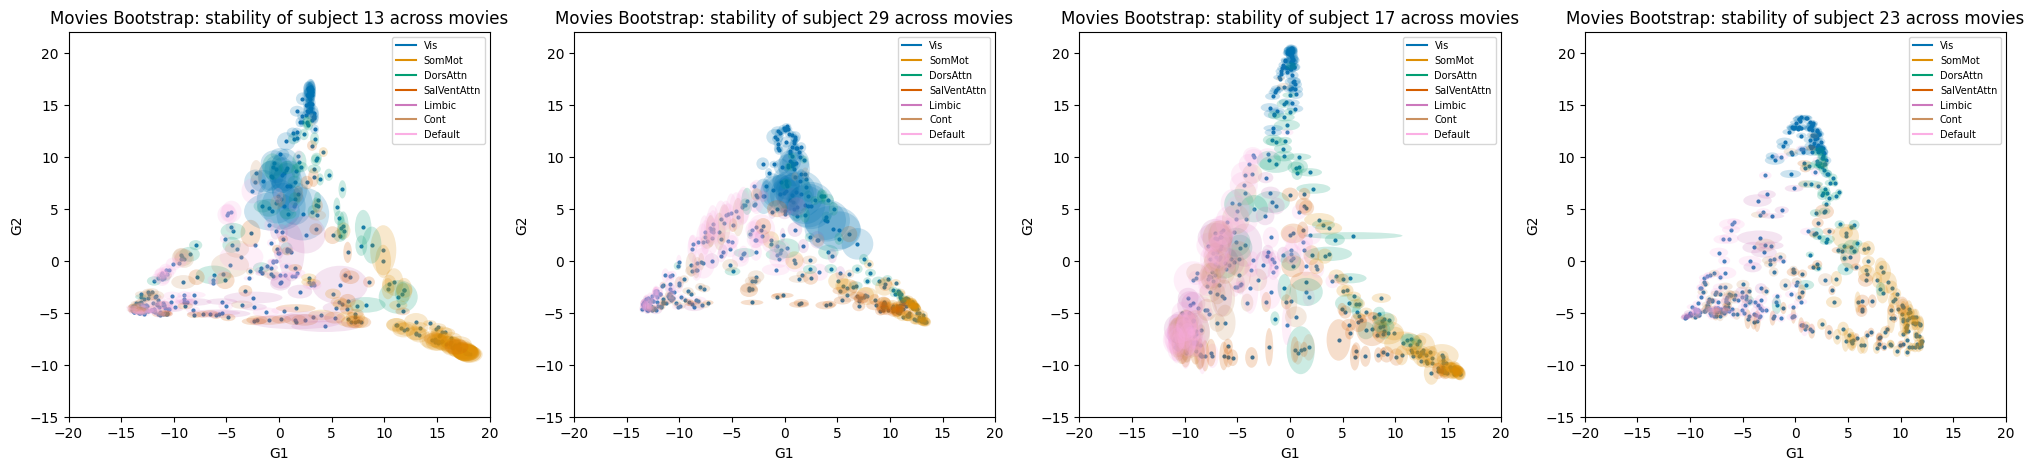

In [26]:
from brainspace.gradient import procrustes_alignment
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)


partial_region = load('./resources/region400yeo7.pkl')
colors = {N: my_cmap.colors[idx] for idx, N in enumerate(list(index2region.keys()))}


_, gref = procrustes_alignment(np.concatenate([np.stack(samples_grad[i]) for i in range(len(samples_grad))]), 
                              return_reference=True, n_iter=100)
fig, axes = plt.subplots(1,4, figsize=(25,5))
aligned_samples = []
for k in range(len(samples_grad)):

    aligned,ref      = procrustes_alignment(samples_grad[k], return_reference=True, n_iter=100)
    aligned          = np.asarray(aligned)
    aligned_samples.append(aligned)
    circle_confusion = aligned.std(axis=0)[:,[0,1]]

    # realign now the individual ref to the group ref
    ref = procrustes_alignment([ref], reference=gref, n_iter=100)[0]
    axes[k].scatter(ref[:,0], ref[:,1], s=4)

    
    for i in range(len(circle_confusion)):
        c       = partial_region[i]
        pts     = circle_confusion[i]
        m       = np.max(pts)
        # cc  = plt.Circle((ref[i][0],ref[i][1]), m ,alpha=0.5, color=colors[c])
        ellipse = Ellipse((ref[i][0],ref[i][1]), width=pts[0] * 2, height=pts[1] * 2,
                            facecolor=colors[c], alpha=0.2)

        # axes[row,col].add_artist(cc)
        axes[k].add_patch(ellipse)

    axes[k].set_title("Movies Bootstrap: stability of subject {} across movies".format(samples_label[k]), size=12)

    C       = list(colors.values())
    labels  = list(colors.keys())
    dummies = [axes[k].plot([], [], ls='-', c=c)[0] for c in C]
    axes[k].legend(dummies, labels, loc=1, prop={'size':7})
    axes[k].set_xlim(-20,20)
    axes[k].set_ylim(-15,22)
    axes[k].set_xlabel('G1')
    axes[k].set_ylabel('G2')    
plt.show()

#### STABILITY ACROSS SUBJECTS

##### Generate gradients from subsets of subjects per movie

In [ ]:
nb_per_sample = 25
subjects      = [c for c in mri_df.filename.unique() if '400' in c]
samples_names = []
samples_grad  = []
nbs = 100
for _ in range(nbs):
    samples_names.append(np.random.choice(subjects, nb_per_sample, replace=False))

for i in tqdm(range(nbs)):
    concat_series = []
    for filename_movie in samples_names[i]:
        movie_series, _ = df_to_timeseries(mri_df, filename_movie)
        movie_series    = movie_series[front_pad : front_pad + duration_film]
        concat_series.append(movie_series)
    concat_series       = np.concatenate(concat_series)

    fc_movie = FC(concat_series)
    g        = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
    g.fit(fc_movie)
    samples_grad.append(g.gradients_)

# save('./resources/sample_grad/'+movie_name.split('_')[0] + '_samples.pkl', samples_grad)

100%|██████████| 10/10 [02:13<00:00, 13.34s/it]


##### Visualize Variance across Sampled Gradients for each Movies

In [7]:
samples_grad  = []
samples_label = []
for sample in os.listdir('./resources/sample_grad/'):
    samples_grad.append(load('./resources/sample_grad/'+sample))
    samples_label.append(sample.split('_')[0])

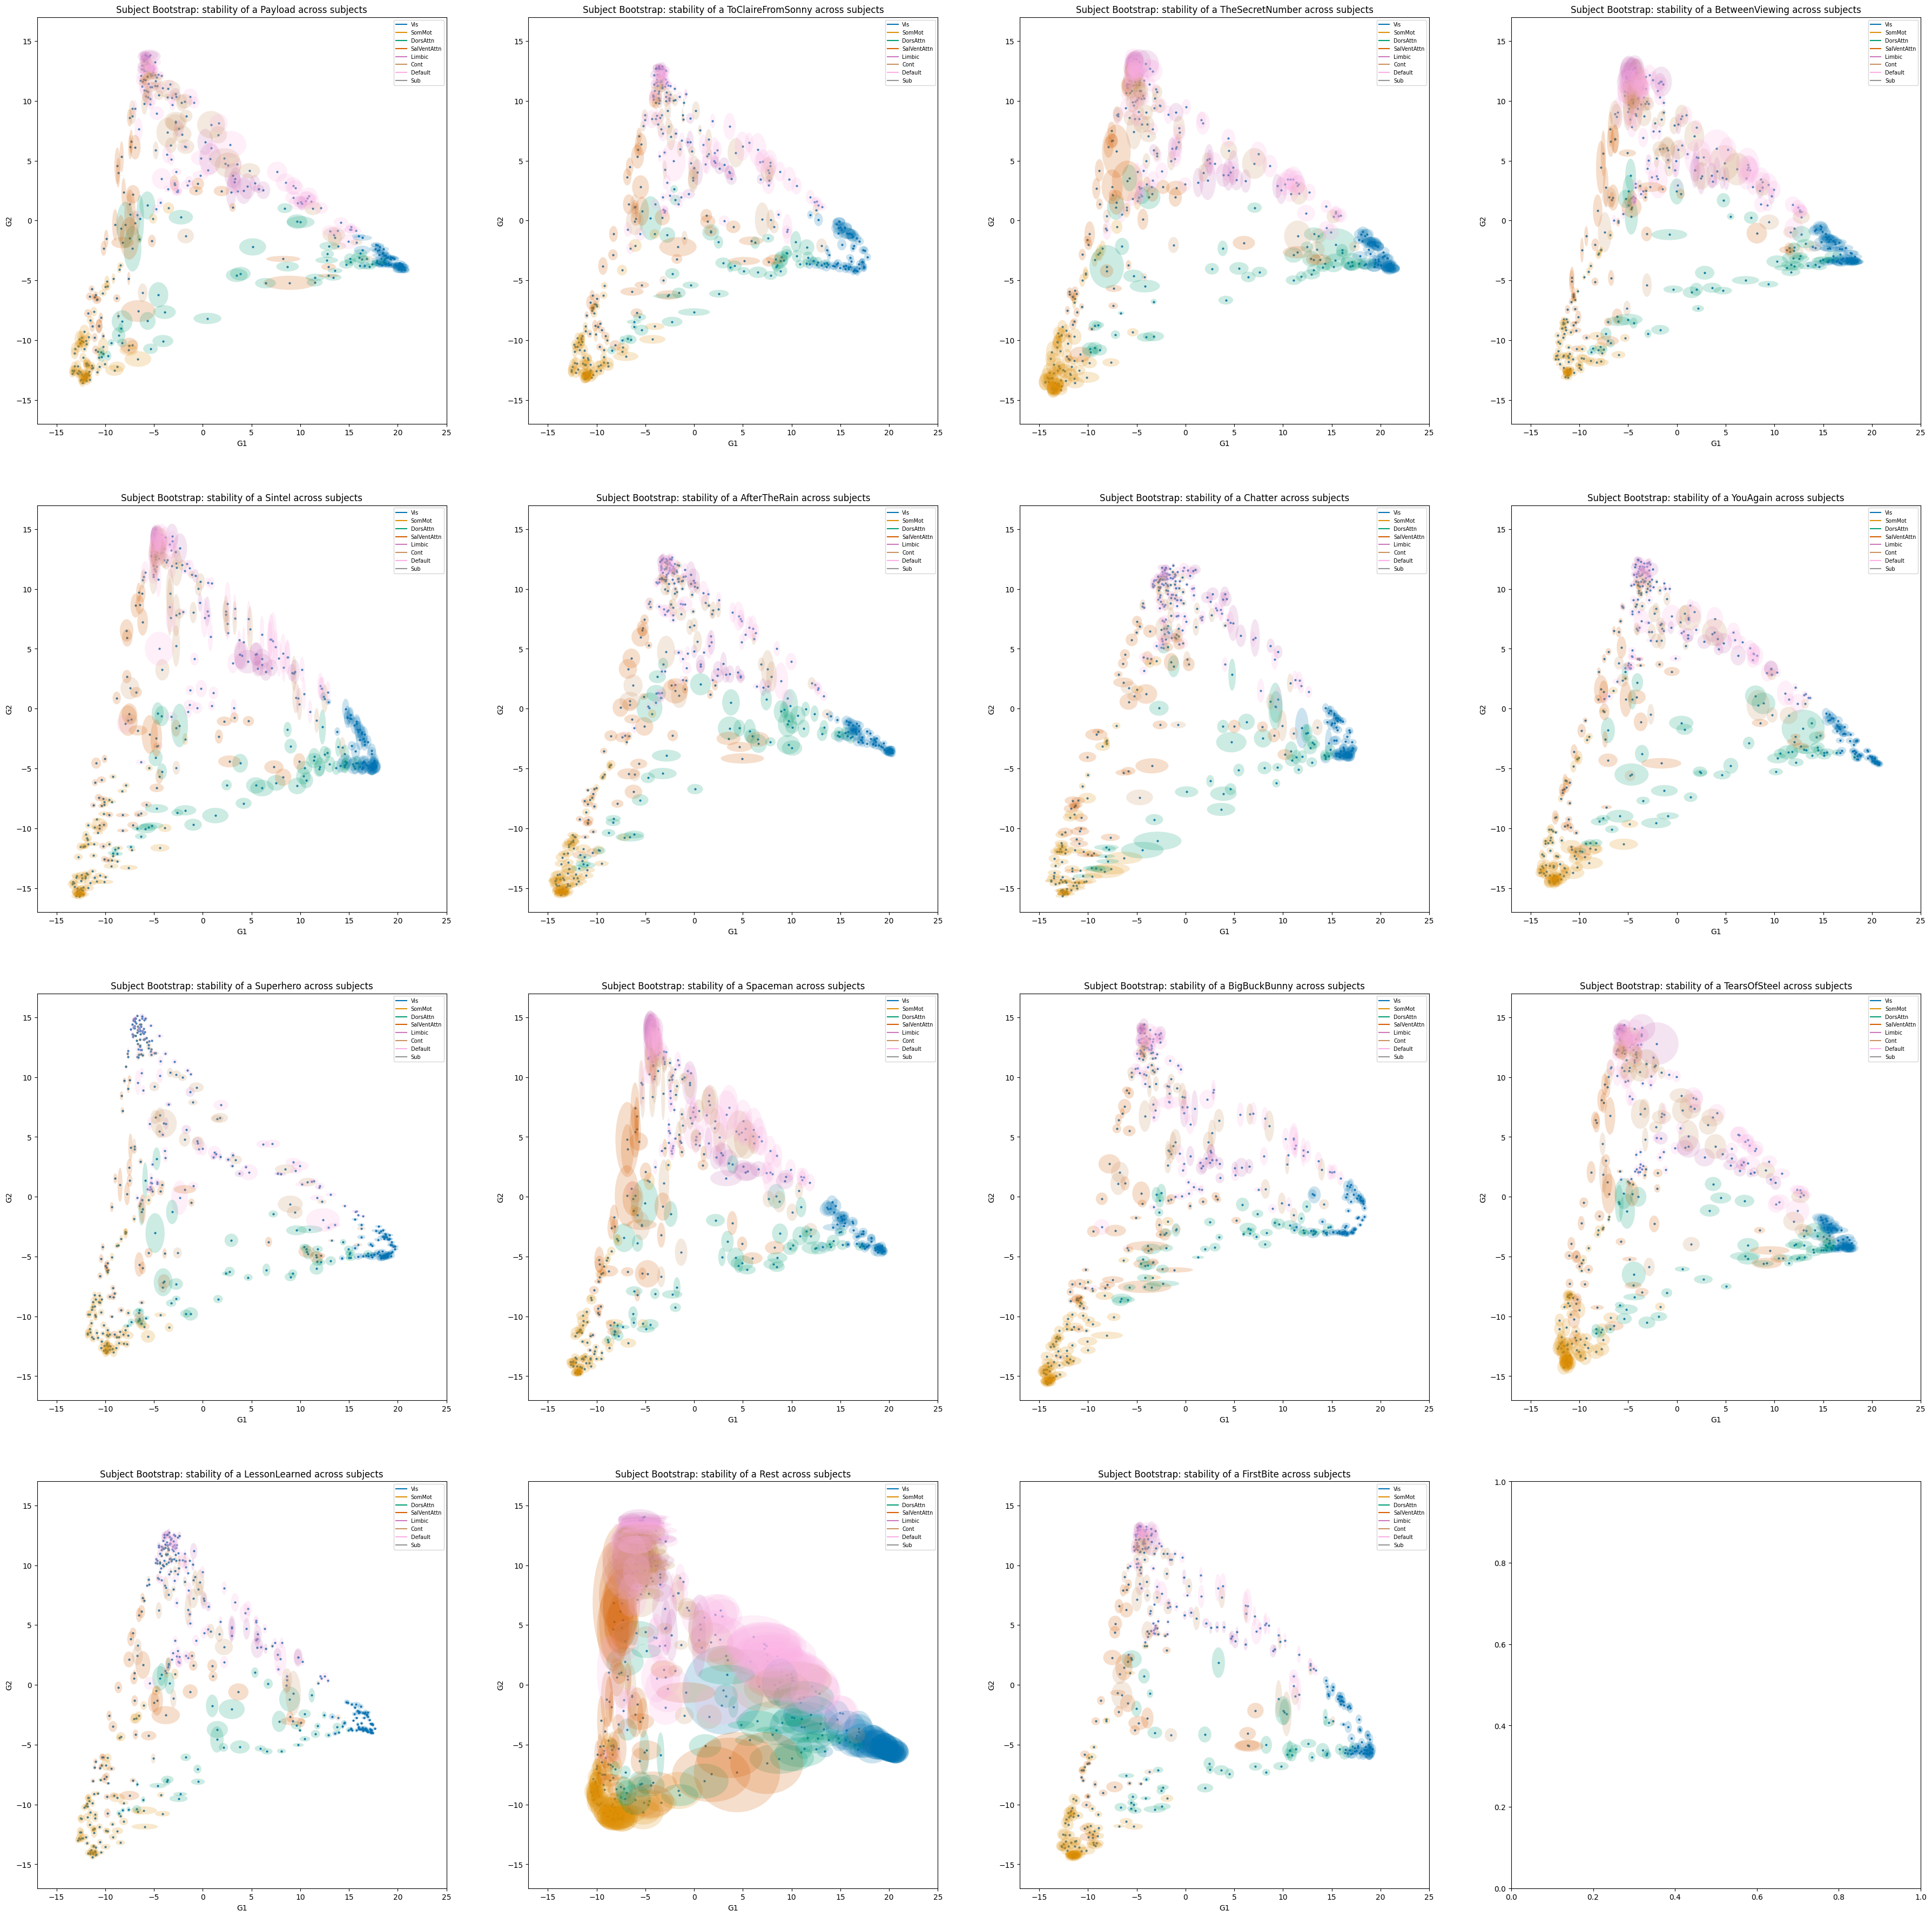

In [6]:
from brainspace.gradient import procrustes_alignment
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)


partial_region = load('./resources/region400yeo7.pkl')
colors = {N: my_cmap.colors[idx] for idx, N in enumerate(list(index2region.keys()))}
# colors         = {'Vis': my_cmap.colors[idx], 'Default':'tab:orange', 'Cont':'tab:green', 'DorsAttn':'tab:red', 'Limbic':'tab:purple', 'SalVentAttn': 'tab:brown', 'SomMot': 'tab:pink'}


fig, axes = plt.subplots(4,4, figsize=(45,45))

refs = []
for k in range(len(samples_grad)):
    _,ref        = procrustes_alignment(samples_grad[k], return_reference=True, n_iter=100)
    refs.append(ref)

ref_align, _ , _ = procrustes_align(refs)

aligned_samples = []
for k in range(len(samples_grad)):
    row,col = k//4, k%4

    aligned,_        = procrustes_alignment(samples_grad[k], return_reference=True, n_iter=100)
    aligned          = np.asarray(aligned)
    aligned_samples.append(aligned)
    circle_confusion = aligned.std(axis=0)[:,[0,1]]

    ref = ref_align[k]
    axes[row,col].scatter(ref[:,0], ref[:,1], s=4)

    for i in range(len(circle_confusion)):
        c   = partial_region[i]
        pts = circle_confusion[i]
        m   = np.max(pts)
        # cc  = plt.Circle((ref[i][0],ref[i][1]), m ,alpha=0.5, color=colors[c])
        ellipse = Ellipse((ref[i][0],ref[i][1]), width=pts[0] * 2, height=pts[1] * 2,
                            facecolor=colors[c], alpha=0.2)

        # axes[row,col].add_artist(cc)
        axes[row,col].add_patch(ellipse)

    axes[row,col].set_title("Subject Bootstrap: stability of a {} across subjects".format(samples_label[k]), size=12)

    CN      = list(colors.values())
    labels  = list(colors.keys())
    dummies = [axes[row,col].plot([], [], ls='-', c=c)[0] for c in CN]
    axes[row,col].legend(dummies, labels, loc=1, prop={'size':7})
    axes[row,col].set_xlim(-17,25)
    axes[row,col].set_ylim(-17,17)
    axes[row,col].set_xlabel('G1')
    axes[row,col].set_ylabel('G2')

plt.show()

##### Quantify Variance across Sampled Gradients for each Movies using ANOVA

In [10]:
samples_label

['Payload',
 'ToClaireFromSonny',
 'TheSecretNumber',
 'BetweenViewing',
 'Sintel',
 'AfterTheRain',
 'Chatter',
 'YouAgain',
 'Superhero',
 'Spaceman',
 'BigBuckBunny',
 'TearsOfSteel',
 'LessonLearned',
 'Rest',
 'FirstBite']

In [11]:
idx = 13
jdx = 4

rest_grads,_,s = procrustes_align(samples_grad[idx], n_iter=100)
rest_grads     = np.asarray(rest_grads)

sintel_grads,_,s = procrustes_align(samples_grad[jdx],  n_iter=100)
sintel_grads     = np.asarray(sintel_grads)

bootstrap_rest   = rest_grads.std(axis=0)[:,0]
bootstrap_sintel = sintel_grads.std(axis=0)[:,0]

In [14]:
# Performing two-way ANOVA
yeo2region = load('./resources/yeo7region400.pkl')
networks   = list(yeo2region.keys())

df = {"score": [], "cond": [], 'network': []}
for n in networks:

    df['score'] += list(bootstrap_rest[yeo2region[n]])
    df['score'] += list(bootstrap_sintel[yeo2region[n]])
    df['cond']  += ['rest'] * len(yeo2region[n])
    df['cond']  += ['movie'] * len(yeo2region[n])
    df['network'] += [n] * 2 * len(yeo2region[n])
    
df = pd.DataFrame.from_dict(df)


model = ols('score ~ C(cond) + C(network) + C(cond):C(network)',data=df).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
print(result.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &     df &      sum\_sq &     mean\_sq &           F &         PR(>F) \\
\midrule
C(cond)            &    1.0 &  241.658218 &  241.658218 &  701.944217 &  4.910491e-111 \\
C(network)         &    6.0 &   24.499767 &    4.083294 &   11.860739 &   9.133746e-13 \\
C(cond):C(network) &    6.0 &   36.687572 &    6.114595 &   17.761055 &   2.294153e-19 \\
Residual           &  786.0 &  270.596088 &    0.344270 &         NaN &            NaN \\
\bottomrule
\end{tabular}



Plot interaction terms details

In [15]:
networks

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']

In [20]:
movie_arr[np.argsort(rest_arr[:,0])]

array([[0.50303487, 0.13269915],
       [0.53748711, 0.20773618],
       [0.44377263, 0.08013601],
       [0.69431556, 0.25591993],
       [0.55211694, 0.23998746],
       [0.40053695, 0.13384376],
       [0.39672442, 0.16553125]])

In [31]:
rest_arr

array([[1.038521  , 0.46885049],
       [1.36275379, 1.05571663],
       [1.36498836, 0.62455011],
       [1.58128538, 0.82706473],
       [1.70069626, 0.63787402],
       [1.90162415, 0.77226634],
       [2.09732713, 1.00943094]])

In [30]:
rest_arr[:,0]

array([1.038521  , 1.36275379, 1.36498836, 1.58128538, 1.70069626,
       1.90162415, 2.09732713])

In [29]:
order

array([1, 3, 0, 2, 4, 5, 6])

In [27]:
np.array(networks)[order]

array(['SomMot', 'SalVentAttn', 'Vis', 'DorsAttn', 'Limbic', 'Cont',
       'Default'], dtype='<U11')

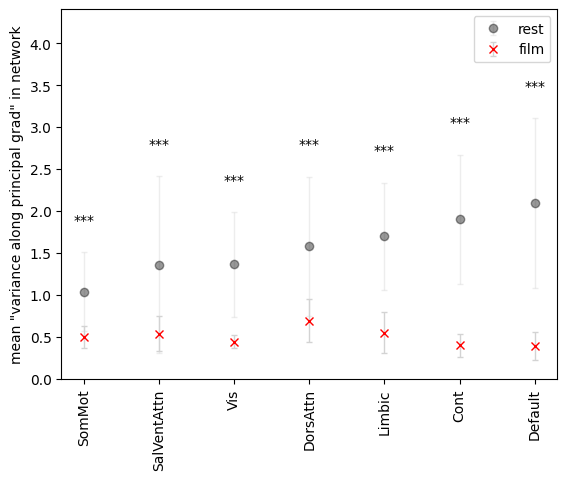

In [35]:
# plot of scatter
rest_df  = df[df.cond == 'rest']
movie_df = df[df.cond == 'movie']
rest_arr  = []
movie_arr = []
for n in networks:
    cur = np.array(rest_df[rest_df.network==n]['score'])
    rest_arr.append([cur.mean(), cur.std()])
    
    cur = np.array(movie_df[movie_df.network==n]['score'])
    movie_arr.append([cur.mean(), cur.std()])
    
rest_arr  = np.asarray(rest_arr)
movie_arr = np.asarray(movie_arr)

order     = np.argsort(rest_arr[:,0])
rest_arr  = rest_arr[order]
movie_arr = movie_arr[order]

plt.errorbar(list(range(rest_arr.shape[0])), rest_arr[:,0], yerr=rest_arr[:,1], fmt='o', color='black',
             ecolor='lightgray', elinewidth=1, capsize=2, alpha=0.4, label='rest');

plt.errorbar(list(range(movie_arr.shape[0])), movie_arr[:,0], yerr=movie_arr[:,1], fmt='x', color='red',
             ecolor='lightgray', elinewidth=1, capsize=2, label='film');

# two-sample t-test
import scipy.stats as stats

lheight = []
for idx,n in enumerate(np.array(networks)[order]):
    pval = stats.ttest_ind(a=np.array(rest_df[rest_df.network==n]['score']), 
                    b=np.array(movie_df[movie_df.network==n]['score'])
                    , equal_var=False).pvalue
    c1, c2, c3 = int(pval < 0.01), int(pval < 0.005), int(pval < 0.001) 
    nbstars = c1 + c2 + c3
    height  = max(rest_arr[idx,0] + rest_arr[idx,1],
                  movie_arr[idx,0] + movie_arr[idx,1]) + 0.3
    lheight.append(height)
    plt.text(idx, height, 
             '*' * nbstars, ha='center', va='bottom')
    
    
plt.ylabel('mean "variance along principal grad" in network')
# plt.xlabel('networks')
plt.xticks(list(range(rest_arr.shape[0])), 
           np.array(networks)[order], rotation=90)
plt.ylim(0,max(lheight) + 1)
plt.legend()
plt.show()



### Ancova 

In [5]:
dct = {}
for file in os.listdir('./resources/static_grad/individual_level/'):
    if '414' in file: continue
    if 'SUPERMOVIE' in file: continue
    tmp = load('./resources/static_grad/individual_level/'+file)
    dct[file[:-4].split('_')[0]] = tmp

all_grad = [list(k.values()) for k in list(dct.values())]
all_grad = np.asarray(all_grad)[...,:2]
all_grad = np.concatenate(all_grad)

# Compute reference grad to align on 
tmpalign, ref, score = procrustes_align(all_grad)

all_grad = [list(k.values()) for k in list(dct.values())]
all_grad = np.asarray(all_grad)[...,:3]
all_grad = np.concatenate(all_grad)
_, ref3, _ = procrustes_align(all_grad)

Ancova test all personality indexes covariates

In [9]:
# Loading behavioural scores
behavioural  = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
existing_psy = list(behavioural.columns[-15:])
# Not Rest specifically 
subject_grad = load('./resources/static_grad/individual_level/Rest_grad400.pkl')
subjects     = list(subject_grad.keys())

movies = list(dct.keys())

In [12]:
# Grad with distance to centroid of 3
cutoff = 0.05/400

grad_per_index = {e:([],[]) for e in existing_psy}
for i in tqdm(range(400)):
        df = {"score": [], "Subject": [], "Movie": []}
        for m in movies:
                for s in subjects:
                        cur_grad = dct[m][s][:,:3]
                        cur_grad = procrustes_align([cur_grad], ref=ref3)[0][0]
                        
                        dist = points_distance(cur_grad[i],cur_grad.mean(axis=0), pmethod="L2")

                        df['score'].append(dist)
                        df['Subject'].append(s)
                        df['Movie'].append(m)

        df = pd.DataFrame.from_dict(df)

        # add personality indexes as covariates
        for i in range(len(existing_psy)):
                feat     = existing_psy[i]
                psyscore = [behavioural[behavioural.ID == _id][feat].item() for _id in list(df['Subject'])]
                df[feat] = psyscore

        # perform Ancova
        summary = ancova(data=df, dv='score', covar=existing_psy, between='Subject')
        for i in range(len(existing_psy)):
                feat     = existing_psy[i]
                fval = summary[summary['Source'] == feat]['F'].iloc[0]
                pval = summary[summary['Source'] == feat]['p-unc'].iloc[0]

                # update non-thresholded grad
                grad_per_index[feat][0].append(fval)

                # update thresholded grad
                grad_per_index[feat][1].append(fval * (pval < cutoff))

100%|██████████| 400/400 [09:34<00:00,  1.44s/it]


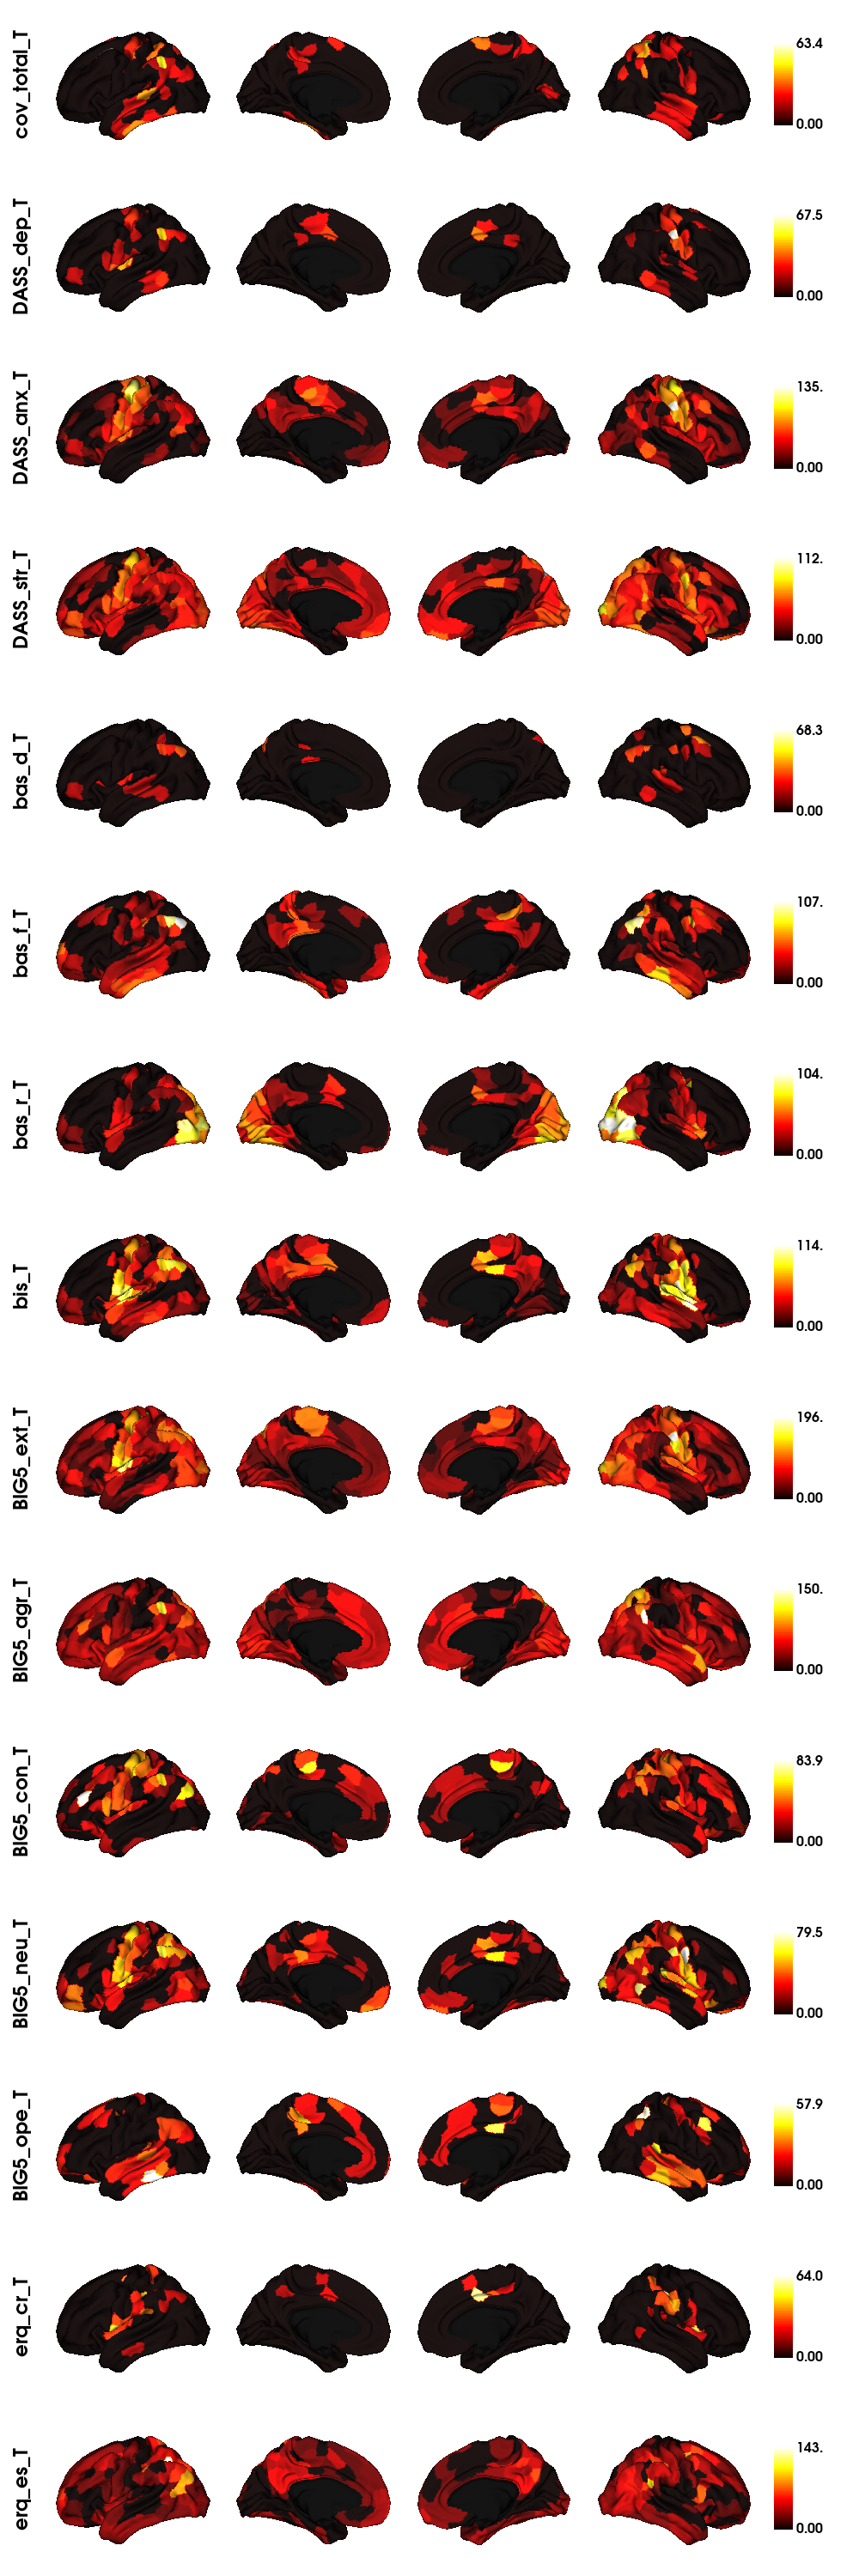

In [13]:
# For a single movie: plots correlation of parcels versus emotions series
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

gs   = np.concatenate([np.array(grad_per_index[e][1])[None] for e in existing_psy])

grad = [None] * len(existing_psy)
for k in range(len(existing_psy)):
    # map the gradient to the parcels
    # gs[k][0]   = gs.min()
    grad[k] = map_to_labels(gs[k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 200 * len(existing_psy)), cmap='hot',
                 color_bar=True, label_text=[e+'_T' for e in existing_psy], zoom=1.15, embed_nb=True, interactive=False,
                 transparent_bg=False)

### ANOVA

Example of 1 Anova test on 1 region/parcel

In [14]:
# Generate dataframe for ANOVA
movies = list(dct.keys())
subjects = list(dct[movies[0]].keys())
df = {"score": [], "Subject": [], "Movie": []}
for m in movies:
    for s in subjects:
        cur_grad = dct[m][s][:,:2]
        cur_grad = procrustes_align([cur_grad], ref=ref)[0][0]
        
        dist = points_distance(cur_grad[0],cur_grad.mean(axis=0), pmethod="L2")

        df['score'].append(dist)
        # df['score'].append(network_volume(cur_grad, "all"))
        # df['score'].append(cur_grad[:,1].max()-cur_grad[:,1].min())
        df['Subject'].append(s)
        df['Movie'].append(m)

df = pd.DataFrame.from_dict(df)

lm = ols("score ~ C(Subject) * C(Movie)", data=df).fit()

reg1 = anova_lm(ols("score ~ C(Subject) + C(Movie)", data=df).fit(), lm)
reg2 = anova_lm(
        ols("score ~ C(Subject)", data=df).fit(),
        ols("score ~ C(Subject) + C(Movie, Sum)", data=df).fit(),
        )
reg3 = anova_lm(
        ols("score ~ C(Movie)", data=df).fit(),
        ols("score ~ C(Subject) + C(Movie, Sum)", data=df).fit(),
    )

res = stat()
res.anova_stat(df=df[['score','Movie']], res_var='score', anova_model='score ~ C(Movie)')
# res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
print(res.anova_summary)

res = stat()
res.anova_stat(df=df[['score','Subject']], res_var='score', anova_model='score ~ C(Subject)')
# res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
print(res.anova_summary)

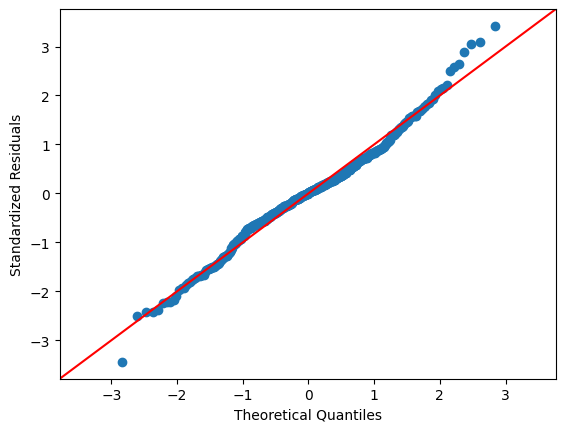

In [17]:
# credit: https://www.reneshbedre.com/blog/anova.html
# quick verification of assumption for normally distributed residuals
import statsmodels.api as sm

sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

#### F-Score Maps Subject and Movies (cond1: including rest, cond2: not including rest) SCORE: distance to gradient centroid

In [53]:
# CONDITION1: including rest
# Generate dataframe for ANOVA
movies = list(dct.keys())
subjects = list(dct[movies[0]].keys())
cutoff = 0.05/400
withrest_fscore = np.zeros((400,2))
for i in tqdm(range(400)):
        df = {"score": [], "Subject": [], "Movie": []}
        for m in movies:
                for s in subjects:
                        cur_grad = dct[m][s]
                        cur_grad = procrustes_align([cur_grad], ref=ref3)[0][0]
                        
                        dist     = points_distance(cur_grad[i],cur_grad.mean(axis=0), pmethod="L2")

                        df['score'].append(dist)
                        df['Subject'].append(s)
                        df['Movie'].append(m)

        df = pd.DataFrame.from_dict(df)

        res = stat()
        res.anova_stat(df=df[['score','Movie']], res_var='value', anova_model='score ~ C(Movie)')
        # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withrest_fscore[i][0] = res.anova_summary.iloc[0,-2]

        res = stat()
        res.anova_stat(df=df[['score','Subject']], res_var='value', anova_model='score ~ C(Subject)')
        # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withrest_fscore[i][1] = res.anova_summary.iloc[0,-2]

100%|██████████| 400/400 [00:31<00:00, 12.73it/s]


In [54]:
# CONDITION 2: not including rest
# Generate dataframe for ANOVA
movies = list(dct.keys())
subjects = list(dct[movies[0]].keys())
cutoff = 0.05/400
withoutrest_fscore = np.zeros((400,2))
for i in tqdm(range(400)):
        df = {"score": [], "Subject": [], "Movie": []}
        for m in movies:
                if m == "Rest": continue
                for s in subjects:
                        cur_grad = dct[m][s]
                        cur_grad = procrustes_align([cur_grad], ref=ref3)[0][0]
                        
                        dist = points_distance(cur_grad[i],cur_grad.mean(axis=0), pmethod="L2")

                        df['score'].append(dist)
                        df['Subject'].append(s)
                        df['Movie'].append(m)

        df = pd.DataFrame.from_dict(df)

        res = stat()
        res.anova_stat(df=df[['score','Movie']], res_var='value', anova_model='score ~ C(Movie)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withoutrest_fscore[i][0] = res.anova_summary.iloc[0,-2]

        res = stat()
        res.anova_stat(df=df[['score','Subject']], res_var='value', anova_model='score ~ C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withoutrest_fscore[i][1] = res.anova_summary.iloc[0,-2]

100%|██████████| 400/400 [00:29<00:00, 13.58it/s]


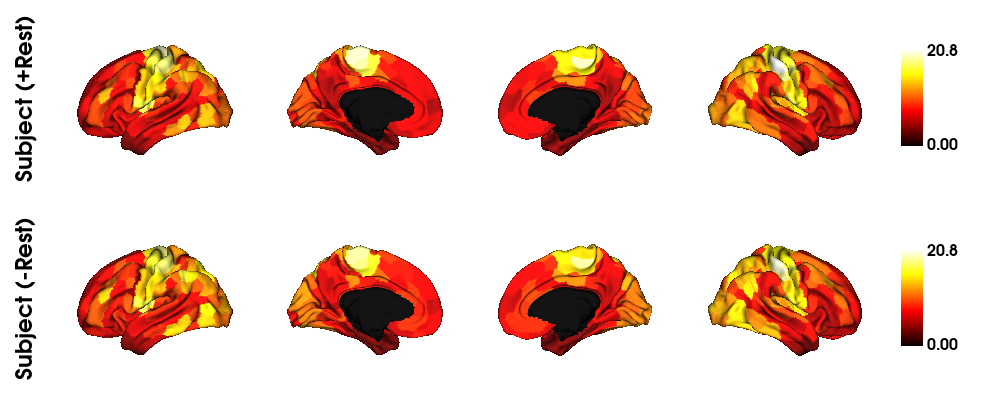

In [60]:
cranges = [(0,gs[[0,2]].max()), (0,gs[[0,2]].max())]
cranges = [(0,gs[[1,3]].max()), (0,gs[[1,3]].max())]

lbtext = np.array(['Movie (+Rest)', 'Subject (+Rest)', 'Movie (-Rest)', 'Subject (-Rest)'])

# For a single movie: plots correlation of parcels versus emotions series
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

gs   = np.concatenate([withrest_fscore, withoutrest_fscore], axis=1).T

grad = [None] * 2
for idx,k in enumerate([1,3]):
    # map the gradient to the parcels
    grad[idx] = map_to_labels(gs[k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 400), cmap='hot',
                 color_bar=True,
                 label_text=lbtext[[1,3]], 
                 zoom=1, embed_nb=True, interactive=False, transparent_bg=False, color_range=cranges)

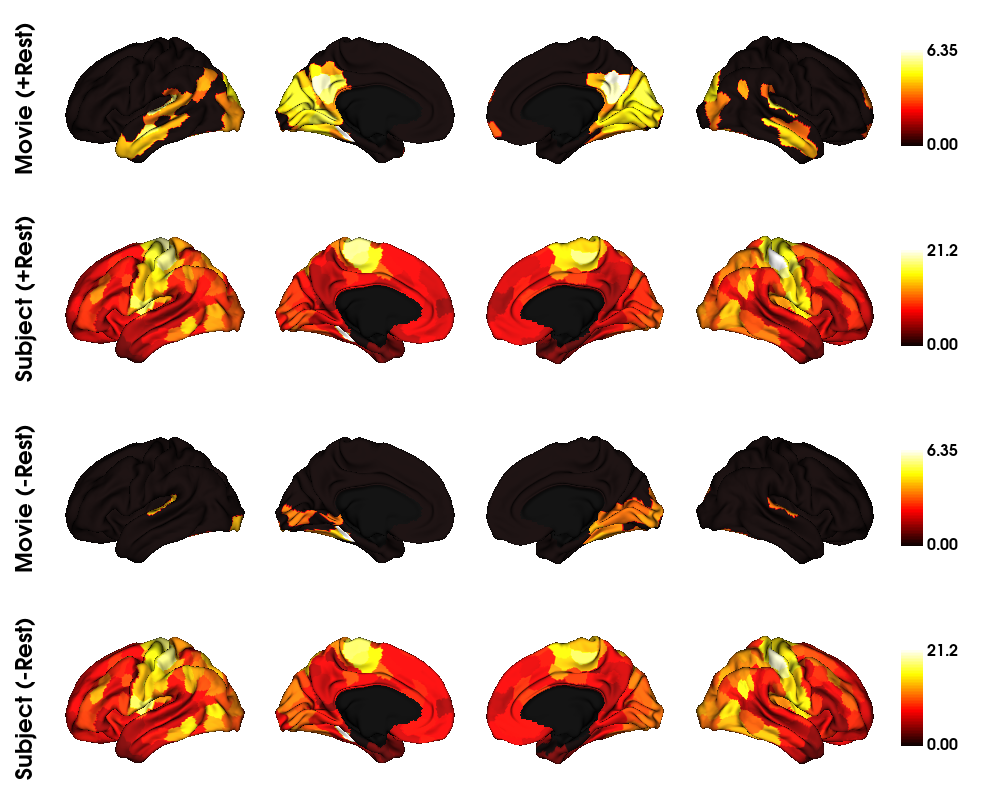

In [59]:
# For a single movie: plots correlation of parcels versus emotions series
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

gs   = np.concatenate([withrest_fscore, withoutrest_fscore], axis=1).T

grad = [None] * 4
for k in range(gs.shape[0]):
    # map the gradient to the parcels
    # gs[k][0]   = gs.min()
    if k in [0,2]:
        gs[k][1]   = gs[[0,2]].max()
    else:
        gs[k][1]   = gs[[1,3]].max()
    grad[k] = map_to_labels(gs[k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 800), cmap='hot',
                 color_bar=True,
                 label_text=['Movie (+Rest)', 'Subject (+Rest)', 'Movie (-Rest)', 'Subject (-Rest)'], 
                 zoom=1.15, embed_nb=True, interactive=False, transparent_bg=False)

#### F-Score Maps Subject and Movies (cond1: including rest, cond2: not including rest) SCORE: variance of dynamic gradients

In [65]:
# CONDITION1: including rest
# Generate dataframe for ANOVA
movies = list(dct_dyn.keys())
subjects = list(dct[movies[0]].keys())
cutoff = 0.05/400
withrest_fscore = np.zeros((400,2))
for i in tqdm(range(400)):
        df = {"score": [], "Subject": [], "Movie": []}
        for m in movies:
                for s in subjects:
                        dist = dct_dyn[m][s][i]

                        df['score'].append(dist)
                        df['Subject'].append(s)
                        df['Movie'].append(m)

        df = pd.DataFrame.from_dict(df)

        res = stat()
        res.anova_stat(df=df[['score','Movie']], res_var='value', anova_model='score ~ C(Movie)')
        # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withrest_fscore[i][0] = res.anova_summary.iloc[0,-2]

        res = stat()
        res.anova_stat(df=df[['score','Subject']], res_var='value', anova_model='score ~ C(Subject)')
        # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withrest_fscore[i][1] = res.anova_summary.iloc[0,-2]

100%|██████████| 400/400 [00:06<00:00, 57.38it/s]


In [66]:
# CONDITION 2: not including rest
# Generate dataframe for ANOVA
movies = list(dct_dyn.keys())
subjects = list(dct[movies[0]].keys())
cutoff = 0.05/400
withoutrest_fscore = np.zeros((400,2))
for i in tqdm(range(400)):
        df = {"score": [], "Subject": [], "Movie": []}
        for m in movies:
                if m == "Rest": continue
                for s in subjects:
                        dist = dct_dyn[m][s][i]

                        df['score'].append(dist)
                        df['Subject'].append(s)
                        df['Movie'].append(m)

        df = pd.DataFrame.from_dict(df)

        res = stat()
        res.anova_stat(df=df[['score','Movie']], res_var='value', anova_model='score ~ C(Movie)')
        # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withoutrest_fscore[i][0] = res.anova_summary.iloc[0,-2]

        res = stat()
        res.anova_stat(df=df[['score','Subject']], res_var='value', anova_model='score ~ C(Subject)')
        # res.anova_stat(df=df, res_var='score', anova_model='score~C(Movie)+C(Subject)+C(Movie):C(Subject)')
        if res.anova_summary.iloc[0,-1] < cutoff:
                withoutrest_fscore[i][1] = res.anova_summary.iloc[0,-2]

100%|██████████| 400/400 [00:06<00:00, 65.03it/s]


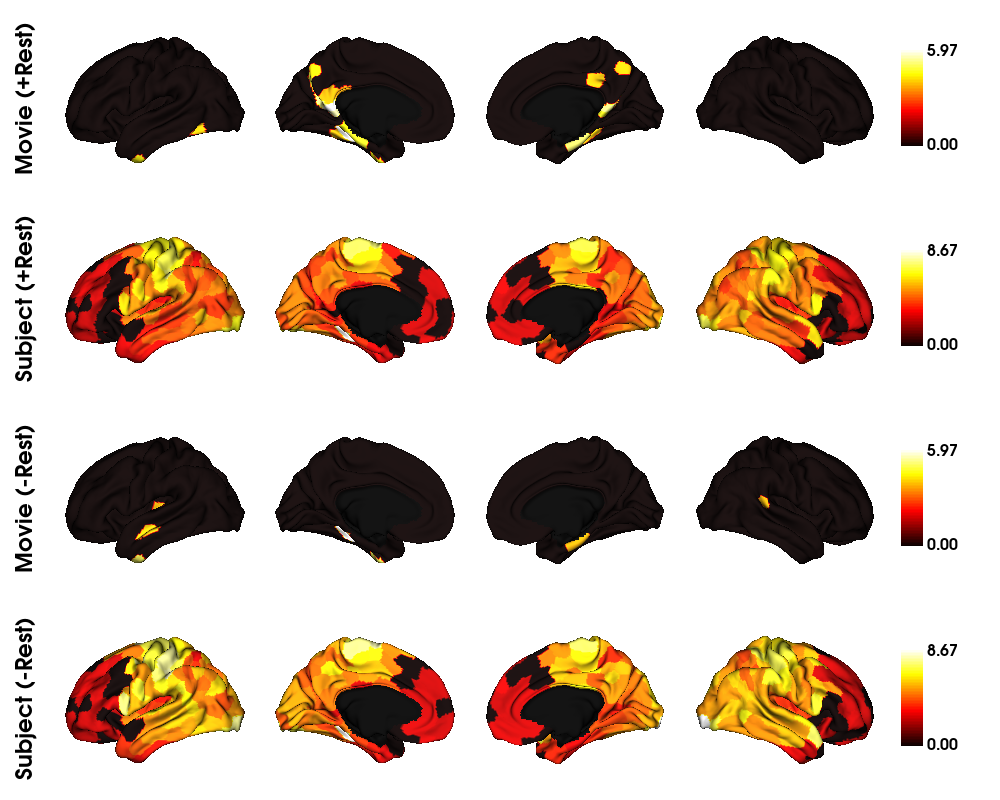

: 

In [67]:
# For a single movie: plots correlation of parcels versus emotions series
labeling         = load_parcellation('schaefer', scale=400, join=True)
surf_lh, surf_rh = load_conte69()
mask = labeling != 0

gs   = np.concatenate([withrest_fscore, withoutrest_fscore], axis=1).T

grad = [None] * 4
for k in range(gs.shape[0]):
    # map the gradient to the parcels
    # gs[k][0]   = gs.min()
    if k in [0,2]:
        gs[k][1]   = gs[[0,2]].max()
    else:
        gs[k][1]   = gs[[1,3]].max()
    grad[k] = map_to_labels(gs[k], labeling, mask=mask, fill=np.nan)

plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(1000, 800), cmap='hot',
                 color_bar=True, label_text=['Movie (+Rest)', 'Subject (+Rest)', 'Movie (-Rest)', 'Subject (-Rest)'], zoom=1.15, embed_nb=True, interactive=False,
                 transparent_bg=False)